# [NTDS'18] milestone 4: graph signal processing
[ntds'18]: https://github.com/mdeff/ntds_2018

[Rodrigo Pena](https://people.epfl.ch/254838), [EPFL LTS2](http://lts2.epfl.ch)

## Students

* Team: 3
* Students: Baptiste Hériard-Dubreuil, Jean-Baptiste Membrado, Guilhem Noiraud, Amaury Véron
* Dataset: Flight routes

## Rules

* Milestones have to be completed by teams. No collaboration between teams is allowed.
* Textual answers shall be short. Typically one to two sentences.
* Code has to be clean.
* You cannot import any other library than we imported.
* When submitting, the notebook is executed and the results are stored. I.e., if you open the notebook again it should show numerical results and plots. We won't be able to execute your notebooks.
* The notebook is re-executed from a blank state before submission. That is to be sure it is reproducible. You can click "Kernel" then "Restart & Run All" in Jupyter.

## Objective

The goal of this milestone is to do some Graph Signal Processing (GSP) on the data of your project.

### A note about plotting

There are several questions in this milestone that ask you to plot a signal on your network.
There are several ways from which you could approach it.
In all cases, compute the position of the nodes a single time at the beginning, as this is likely to be a costly operation.
Using a single layout for all the graph plots will also make it easier to compare the plots.
Indeed, the only thing changing between plots is the signal displayed.
You can represent the features/labels lying on the graph via node **colors**.
To do so, make sure to have a consistent color map throughout and remember to display a colorbar and scale in all plots, so that we can tell what numbers the colors represent.

* An option is to use the **Laplacian eigenmaps** that you have seen in the previous milestone to embed your graph on the plane. For example:
  ```
  from matplotlib import pyplot as plt
  plt.scatter(eigenvectors[:, 1], eigenvectors[:, 2], c=signal, alpha=0.5)
  plt.colorbar()
  ```
* Another option is to use the plotting capabilities of **[NetworkX](https://networkx.github.io)**.
  See the documentation of its [drawing methods](https://networkx.github.io/documentation/stable/reference/drawing.html).
  For example:
  ```
  import networkx as nx
  graph = nx.from_scipy_sparse_matrix(adjacency)
  coords = nx.spring_layout(graph)  # Force-directed layout.
  coords = eigenvectors[:, 1:3]  # Laplacian eigenmaps.
  nx.draw_networkx_nodes(graph, coords, node_size=60, node_color=signal)
  nx.draw_networkx_edges(graph, coords, alpha=0.3)
  ```
* Another option is to use the plotting capabilities of the **[PyGSP](https://github.com/epfl-lts2/pygsp)**, a Python package for Graph Signal Processing.
  **Note that your are forbidden to use the PyGSP for anything else than plotting.**
  See the documentation of its [plotting utilities](https://pygsp.readthedocs.io/en/stable/reference/plotting.html).
  For example:
  ```
  import pygsp as pg
  graph = pg.graphs.Graph(adjacency)
  graph.set_coordinates('spring')  # Force-directed layout.
  graph.set_coordinates(eigenvectors[:, 1:3])  # Laplacian eigenmaps.
  graph.plot_signal(signal)
  ```
* Yet another option is to save your graph on disk, use **[Gephi](https://gephi.org)** externally, to visualize the graph, save the graph with the Gephi coordinates and finally load the nodes coordinates back into the notebook.

We encourage you to try all the above methods before making your choice. Then be consistent and use only one throughout the milestone.
NetworkX and PyGSP should already be installed in your environement. If that's not the case, install with `conda install networkx pygsp` (after activating the `ntds_2018` environment).

## 0 - Load your network

In [1]:
%matplotlib inline

If you get a `No module named 'pyunlocbox'` error when running the below cell, install the [pyunlocbox](https://github.com/epfl-lts2/pyunlocbox) with `conda install pyunlocbox` (after activating the `ntds_2018` environment).

In [2]:
import numpy as np
from scipy import sparse
import scipy.sparse.linalg
from matplotlib import pyplot as plt
from pyunlocbox import functions, solvers
import pandas as pd #imported because we have to upload and modify our dataset

For this milestone, all we will need is a set of features/labels for each of the nodes on the network, as well as the Laplacian, $L,$ and Gradient, $\nabla_G,$ matrices that you have computed for your network while working on milestone 3.

Import those objects in the cell below (or recompute the Laplacian and Gradient from your stored adjacency matrix, if you wish).

_Note_: If your features/labels are not floating-point numbers, please convert them. For example, if your data has labels "cat" and "dog" for nodes that represent cats or dogs, respectively, you may assign the number `1.0` for the label "cat" and the number `-1.0` for the label "dog".  

In [3]:
biggest_cluster = np.load("biggest_cluster.npy")
df_biggest_cluster = pd.read_csv("df_biggest_cluster.csv")
df_biggest_cluster.set_index("airport_id", inplace=True)

In [4]:
df_biggest_cluster.head()

,2965,2966,2968,4029,6156,2922,2952,2990,2948,2962,...,9758,4336,1040,2697,1463,8259,7370,6372,4125,7369
airport_id,,,,,,,,,,,,,,,,,,,,,
2965,0,0,0,1,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
2966,0,0,0,1,0,0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
2968,0,0,0,1,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
4029,1,1,1,0,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
6156,0,0,0,1,0,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
#Load a dataset with more information about the airports
airports = pd.read_csv("airports.dat", header=None)

In [6]:
#Keep only the id of airports and the continents in which they are located
airports_continents = airports[[0, 11]]
airports_continents.columns = ["airport_id", "continent"]
airports_continents.set_index("airport_id", inplace=True)

In [7]:
#Keep only name of continent
airports_continents.continent = airports_continents.continent.apply(lambda x: x.split("/")[0])

C:\Users\guilh\Miniconda3\envs\ntds_2018\lib\site-packages\pandas\core\generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [8]:
#Keep only airports which are in the adjacency matrix
airports_in_data = df_biggest_cluster.index.tolist()
airports_continents = airports_continents.loc[airports_in_data]

C:\Users\guilh\Miniconda3\envs\ntds_2018\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  This is separate from the ipykernel package so we can avoid doing imports until


In [9]:
airports_continents.continent.value_counts() #np.nan are not count by this method

America      1216
Asia          767
Europe        561
Africa        254
Pacific       165
Australia     112
Atlantic       32
Indian         29
\N             24
Arctic          1
Name: continent, dtype: int64

In [10]:
#Create laplacien matrix
sparse_biggest_cluster = sparse.csr_matrix(biggest_cluster)
laplacian_combinatorial =  sparse.csgraph.laplacian(sparse_biggest_cluster)
laplacian_normalized =  sparse.csgraph.laplacian(sparse_biggest_cluster, normed = True)

In [11]:
n_nodes = biggest_cluster.shape[0]

laplacian = laplacian_combinatorial

dico = {}

edges_list = []
for i in range (n_nodes):
    for j in range (i,n_nodes):
        if biggest_cluster[i,j]==1:
            edges_list += [(i,j)]
        
s = np.zeros((n_nodes,len(edges_list)))

for edge_number,edge_coordinates in enumerate(edges_list):
    (i,j) = edge_coordinates
    if i == j: 
        continue
    s[i,edge_number] = -1
    s[j,edge_number] = 1

gradient = scipy.sparse.csr_matrix(np.transpose(s))

dic = {"America":1, "Asia":2,"Europe":3,"Africa":4,"Pacific":5,"Australia":6,"Atlantic":7,"Indian":8,"Arctic":9,"\\N":10,np.nan:10}

labels = airports_continents.continent
labels = np.array(labels.replace(dic).tolist())

#Verification
import networkx as nx
S = nx.incidence_matrix(nx.from_numpy_matrix(biggest_cluster),oriented=True).toarray()
sum(sum(s!=S))

0

## 1 - Graph Fourier Transform

In this section we will observe how your feature/label vector looks like in the "Graph Fourier" domain.

### Question 1

Compute the Fourier basis vectors and the Laplacian eigenvalues. Make sure to order those from smaller to larger, $\lambda_0 \leq \lambda_1 \leq \dots \leq \lambda_{N-1},$ and use the same ordering for the Fourier basis vectors.

In [12]:
computation =  scipy.linalg.eigh(laplacian.toarray())  #Compute orthonormale basis
eigenvectors = computation[1]
eigenvalues =  computation[0]

#Sort to have ordered eigenvalues
idx = eigenvalues.argsort()  
eigenvalues = np.round_(np.real(eigenvalues[idx]), 13) #to avoid the zero approximations
eigenvectors = np.real(eigenvectors[:,idx])

Plot the first 3 and the last Fourier basis vectors as signals on your graph. Clearly indicate which plot belongs to which basis vector.

In [13]:
four_1 = eigenvectors[:,1]
four_2 = eigenvectors[:,2]
four_3 = eigenvectors[:,3]
four_end = eigenvectors[len(eigenvectors)-1]

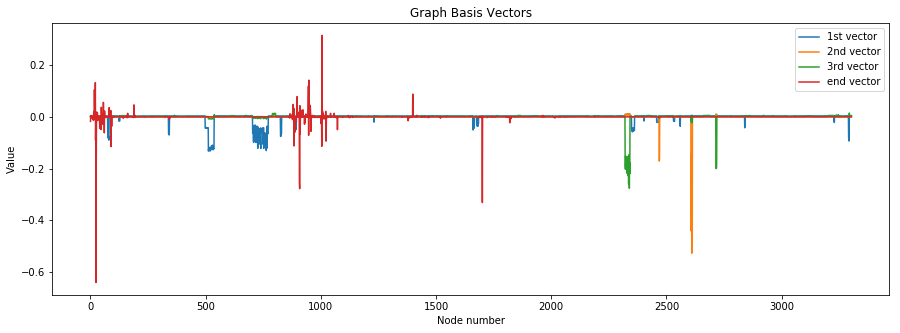

In [14]:
#Plot
plt.figure(figsize=(15,5))
plt.plot(four_1, label = '1st vector')
plt.plot(four_2, label = '2nd vector')
plt.plot(four_3, label = '3rd vector')
plt.plot(four_end, label = 'end vector')
plt.legend(loc='upper right')
plt.title('Graph Basis Vectors')
plt.ylabel('Value');
plt.xlabel('Node number');
plt.show()

C:\Users\guilh\Miniconda3\envs\ntds_2018\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


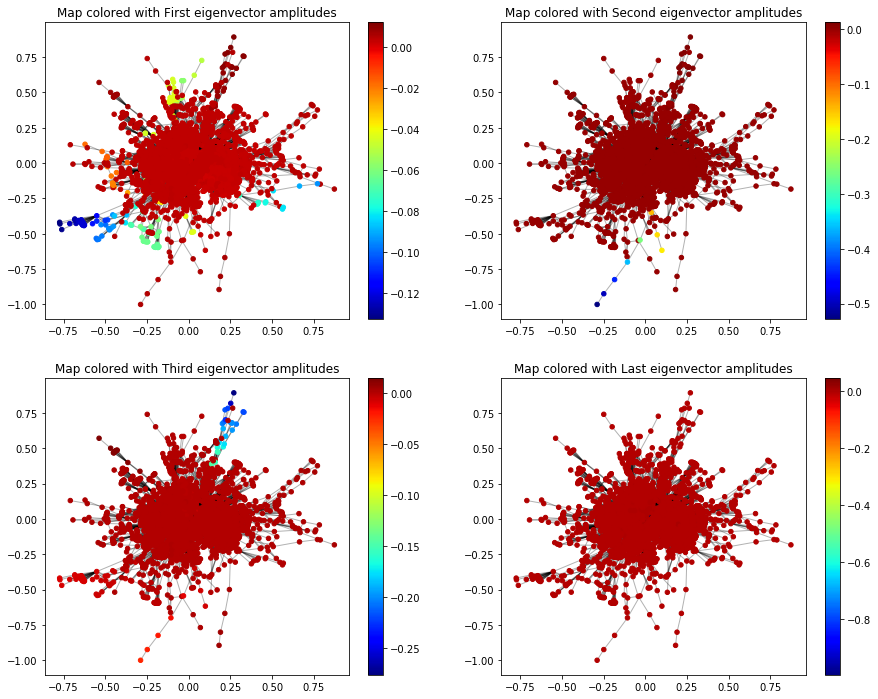

In [15]:
import networkx as nx

fig, ax = plt.subplots(2,2, figsize=(15, 12))

graph = nx.from_numpy_matrix(biggest_cluster)
coords = nx.spring_layout(graph)  # Force-directed layout.

nc = nx.draw_networkx_nodes(graph, coords, node_size=20, node_color=eigenvectors[:,1], cmap=plt.cm.jet, ax=ax[0][0])
nx.draw_networkx_edges(graph, coords, alpha=0.3, ax=ax[0][0])
plt.colorbar(nc, ax=ax[0][0])
ax[0][0].set_title("Map colored with First eigenvector amplitudes")

nc = nx.draw_networkx_nodes(graph, coords, node_size=20, node_color=eigenvectors[:,2], cmap=plt.cm.jet, ax=ax[0][1])
nx.draw_networkx_edges(graph, coords, alpha=0.3, ax=ax[0][1])
plt.colorbar(nc, ax=ax[0][1])
ax[0][1].set_title("Map colored with Second eigenvector amplitudes")

nc = nx.draw_networkx_nodes(graph, coords, node_size=20, node_color=eigenvectors[:,3], cmap=plt.cm.jet, ax=ax[1][0])
nx.draw_networkx_edges(graph, coords, alpha=0.3, ax=ax[1][0])
plt.colorbar(nc, ax=ax[1][0])
ax[1][0].set_title("Map colored with Third eigenvector amplitudes")

nc = nx.draw_networkx_nodes(graph, coords, node_size=20, node_color=eigenvectors[:,-1], cmap=plt.cm.jet, ax=ax[1][1])
nx.draw_networkx_edges(graph, coords, alpha=0.3, ax=ax[1][1])
plt.colorbar(nc, ax=ax[1][1])
ax[1][1].set_title("Map colored with Last eigenvector amplitudes");

### Question 2

What can you observe in terms of local variations when comparing the basis vectors corresponding to the smallest eigenvalues to those corresponding to the largest eigenvalue? How would this justify the interpretation of the eigenvalues as "graph frequencies"?

**Eigenvectors associated with smaller eigenvalues have values that vary less rapidly
along the edges...**

### Question 3

Implement a function that returns the Graph Fourier Transform (GFT) of a given vector $x \in \mathbb{R}^{N},$ with respect to your graph, and a function that computes the corresponding inverse GFT (iGFT).

In [16]:
def GFT(x):
    return eigenvectors.T@x

def iGFT(x):
    return eigenvectors@x

### Question 4

Plot your feature/label vector as a signal on your graph

C:\Users\guilh\Miniconda3\envs\ntds_2018\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


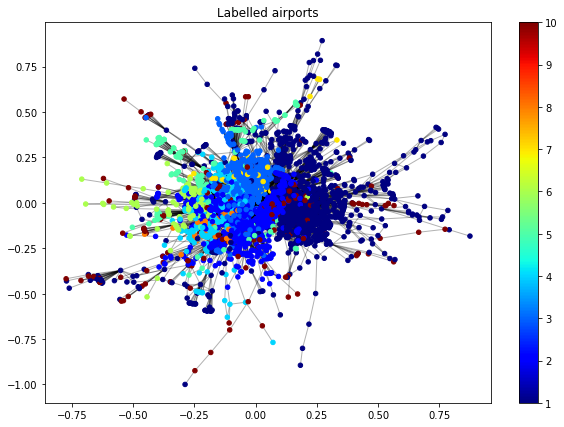

In [17]:
plt.figure(figsize=(10,7))
nc = nx.draw_networkx_nodes(graph, coords, node_size=20, node_color=labels, cmap=plt.cm.jet)
nx.draw_networkx_edges(graph, coords, alpha=0.3)
plt.colorbar(nc)
plt.title("Labelled airports");

Plot the absolute values of the GFT of your feature/label signal as a function of the graph eigenvalues. Make sure to add a marker indicating the position of each graph eigenvalue, and remember to properly name the axes.

In [18]:
GFT_labels = GFT(labels)

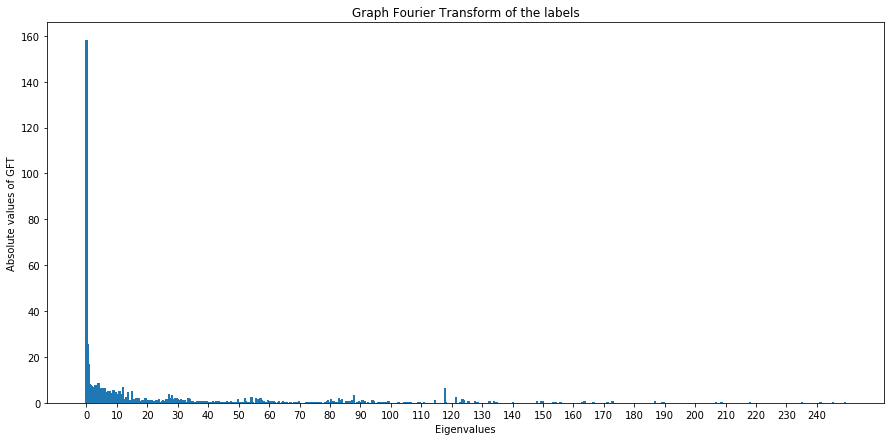

In [19]:
plt.figure(figsize=(15, 7))
plt.bar(eigenvalues, np.abs(GFT_labels))
plt.xticks(ticks=np.arange(0, 250, 10), labels=np.arange(0, 250, 10))
plt.xlabel("Eigenvalues")
plt.ylabel("Absolute values of GFT")
plt.title("Graph Fourier Transform of the labels")
plt.show()

### Question 5

Discuss the behavior of the GFT that you plotted in the last question via comparing the plot of your label signal and those of the Fourier basis of Question 1. Would you consider your labels a "low-pass" or "high-pass" signal, or yet something else entirely?

**We have a low-pass behaviour : by using the analogy with the classical Fourier transform, we see that almost all values of the GFT are concentrated on low eigenvalues. We can understand it with the labels we use in our graph : the labels are the continents on which the airports are situated. Thus, it is logical that airports on the same continent are more likely to be connected ; and it is less likely to be seen for airports on different continents.**

**We thus have a low frequency behaviour : the function associating a node of the graph to its label has little variations, and in the Fourier domain, its components are mainly situated in low frequencies. We see this behaviour in the plot of the labels signal : same-color points are rather close.**

**If we want to compare this graph to the one in question 1, we can say that each point in the GFT of the labels corresponds to the scalar product between the function of the labels and an eigenvector. This means that the eigenvectors associated with the lowest eigenvalues produce great values of scalar product with the labels function.**

## 2 - Filtering on graphs

In this section we will check how filtered Dirac impulses diffuse on your graph.

### Question 6 

Implement the following three filter kernels and the graph filtering operation.

- The **heat kernel** is supposed to take in a vector of eigenvalues `e` and a parameter `t` and output a vector of evaluations of the heat kernel at those eigenvalues (see the course slides for help).
- The **inverse filter** kernel is supposed to take in a vector of eigenvalues `e` and a parameter `t` and implement spectrally the  filter defined in the node domain by $f_{out}  = (I + t L)^{-1} f_{in},$ where $f_{in}, f_{out} \in \mathbb{R}^{N}$ are, repectively, the input and output signals to the filter.
- The **rectangle kernel** takes in a vector of eigenvalues `e` and parameters `l_min` and `l_max` and returns `1.0` at coordinates satisfying $(e[l] \geq l_{min}) \wedge (e[l] \leq l_{max}),$ and `0.0` otherwise.
- The **graph filtering** operation takes a graph signal $x \in \mathbb{R}^{N}$, a spectral graph `kernel` and a set of keyworded variables, and returns the corresponding filtered signal.
    - _Hint:_ Remember that you have implemented the `GFT` and `iGFT` operations in Question 3.
    - The `**kwargs` is a placeholder to collect supplementary pairs of keyword-values that are not known by the implementation before execution time.
      The `kwargs` variable is a dictionary whose keyes and values are the parameter names and values.
      This is useful to allow both `graph_filter(x, heat_kernel, tau=1.0)` and `graph_filter(x, rectangle_kernel, lambda_min=0.0, lambda_max=1.0)` to be valid calls from the same implementation.
      One can then defer the keyword-value assignment to the `kernel` call: `foo = kernel(bar, **kwargs)`.

In [20]:
def heat_kernel(e, t):
    return np.exp(-e*t)

def inverse_kernel(e, t):
    return 1/(1+t*e)

def rectangle_kernel(e, l_min, l_max):
    out = np.zeros(len(e))
    for l in range(len(e)):
        if (l_min<=e[l]) and (l_max>=e[l]):
            out[l] = 1
    return out

def graph_filter(x, kernel, **kwargs):
    gft_x = GFT(x)  
    filt = kernel(eigenvalues, **kwargs)
    return iGFT(np.multiply(filt, gft_x))

### Question 7

Plot all three filter kernels in the spectral domain. Remember to properly name the axes and title the plots. Choose filter parameters that best approximate the behavior of the GFT of your feature/label signal (as seen in Question 4).

**Plot of heat_kernel in spectral domain:**

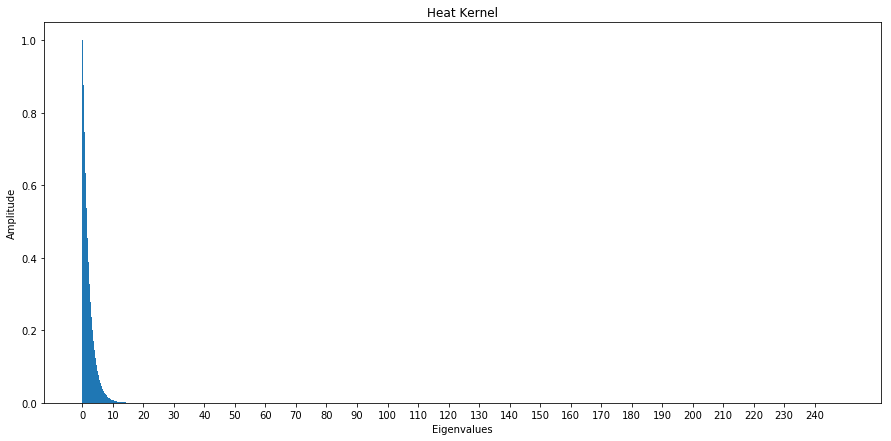

In [21]:
plt.figure(figsize=(15, 7))
y_heat = heat_kernel(eigenvalues, 0.5)
plt.bar(eigenvalues, y_heat, width=0.2)
plt.xticks(np.arange(0, 250, 10))
plt.xlabel("Eigenvalues")
plt.ylabel("Amplitude")
plt.title("Heat Kernel")
plt.show()

In [22]:
t_heat = 0.5

**Plot of inverse_kernel in spectral domain:**

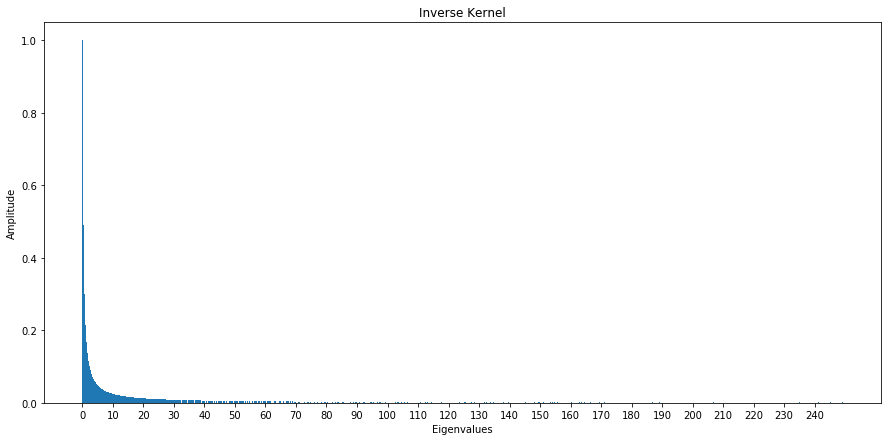

In [23]:
plt.figure(figsize=(15, 7))
y_inverse = inverse_kernel(eigenvalues, 4)
plt.bar(eigenvalues, y_inverse, width=0.2)
plt.xticks(np.arange(0, 250, 10))
plt.xlabel("Eigenvalues")
plt.ylabel("Amplitude")
plt.title("Inverse Kernel")
plt.show()

In [24]:
t_inverse = 4

**Plot of rectangle_kernel in spectral domain:**

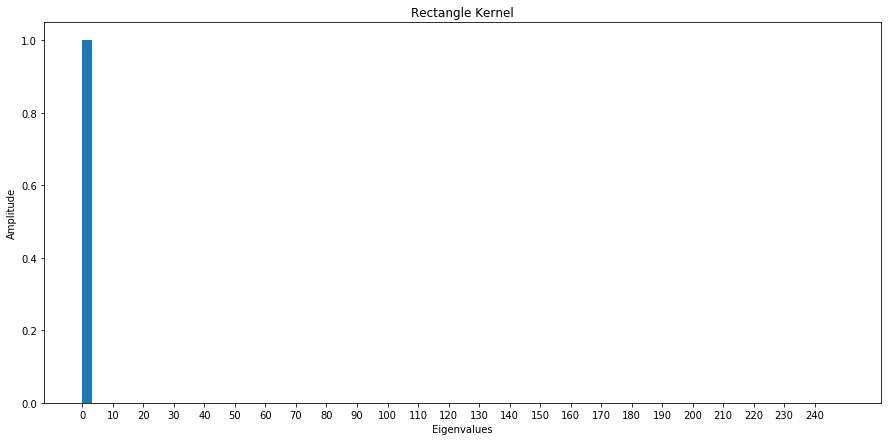

In [25]:
plt.figure(figsize=(15, 7))
y_rectangle = rectangle_kernel(eigenvalues, 0, 3)
plt.bar(eigenvalues, y_rectangle, width=0.2)
plt.xticks(np.arange(0, 250, 10))
plt.xlabel("Eigenvalues")
plt.ylabel("Amplitude")
plt.title("Rectangle Kernel")
plt.show()

In [26]:
l_min = 0
l_max = 3

### Question 8

Consider two Dirac impulses arbitrarily placed on your graph. Plot their filtered versions by the three filter kernels implemented in Question 6.

In [27]:
dirac = np.zeros(n_nodes)
# Place 2 arbitrary Dirac impulses
# We take 1000 as the infinite value for the Dirac since taking np.Inf does not work for visualization
dirac1 = 335 #high degree node --> diffused and not recovered
dirac2 = 1819 #mean-node-degree node (15) --> just recovered with inverse filter
size_dirac = 1000
dirac[dirac1] = size_dirac
dirac[dirac2] = size_dirac

In [28]:
dirac_graph = labels + dirac

In [29]:
#nx.from_numpy_matrix(biggest_cluster).degree #to see interesting nodes

**Filtered version by heat kernel:**

In [30]:
dirac_heat = graph_filter(dirac_graph/size_dirac, heat_kernel, t=t_heat)

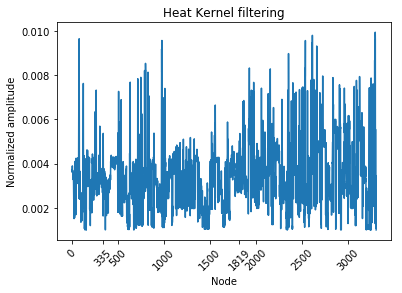

In [31]:
plt.xticks(list(np.arange(0, n_nodes, 500)) + [dirac1, dirac2], rotation=45)
plt.plot(dirac_heat);
plt.xlabel("Node")
plt.ylabel("Normalized amplitude")
plt.title("Heat Kernel filtering")
plt.show()

**Filtered version by inverse kernel:**

In [32]:
dirac_inverse = graph_filter(dirac_graph/size_dirac, inverse_kernel, t=t_inverse)

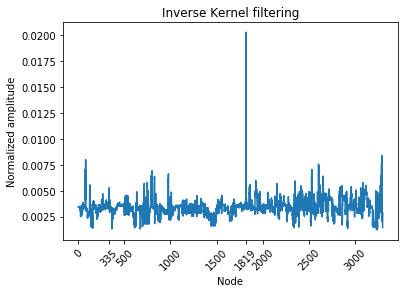

In [33]:
plt.xticks(list(np.arange(0, n_nodes, 500)) + [dirac1, dirac2], rotation=45)
plt.plot(dirac_inverse)
plt.xlabel("Node")
plt.ylabel("Normalized amplitude")
plt.title("Inverse Kernel filtering")
plt.show()

**Filtered version by rectangle kernel:**

In [34]:
dirac_rectangle = graph_filter(dirac_graph/size_dirac, rectangle_kernel, l_min=l_min, l_max=l_max)

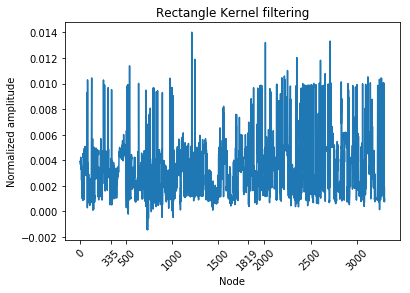

In [35]:
plt.xticks(list(np.arange(0, n_nodes, 500)) + [dirac1, dirac2], rotation=45)
plt.plot(dirac_rectangle)
plt.xlabel("Node")
plt.ylabel("Normalized amplitude")
plt.title("Rectangle Kernel filtering")
plt.show()

Comment on the "diffusion" of the Diracs induced by the filters. What does it say about the "communication" of information across your network? Relate that to the network connectivity measures that you analyzed during the previous milestones.

**Highly connected nodes diffuse very well and it is difficult to recover the original signal. Heat kernel and rectangle kernel are rapidly not sufficient, but the inverse kernel can recover the signal if the degree is not too high.**

## 3 - De-noising

In this section we will add some centered Gaussian noise to your feature/label signal and attempt to recover it.

### Question 9

In the cell below, set the noise variance $\sigma^2$ by making sure that the signal-to-noise ratio $SNR = \frac{\operatorname{Var}(\text{labels})}{\sigma^2}$ is about  $1.5$.

_Note:_ Actually, you might want to play with the noise variance here and set it to different values and see how the denoising filters behave.

In [36]:
noise_variance = np.var(labels)/1.5
noisy_measurements = labels + np.sqrt(noise_variance) * np.random.randn(n_nodes)

### Question 10

In the denoising setting, a common graph signal processing assumption is that the signal $z$ that we want to recover is "smooth", in the sense that $\|\nabla_G z\|_2 = \sqrt{z^{\top} L z}$ is small, while remaining "close" to the measurements that we start with. This leads to denoising by solving the following optimization problem:

$$
z^\star = \text{arg} \, \underset{z \in \mathbb{R}^{N}}{\min} \, \|z - y\|_2^2 + \gamma z^{\top} L z, 
$$

where $y \in \mathbb{R}^{N}$ is the vector of noisy measurements.

Derive the close form solution to this problem giving $z^\star$ as a function of $y$, $\gamma$ and $L$. Does this solution correspond to any graph filtering operation that you know?

**Close form solution of this problem is given by deriving the expression we want to minimize.**

**It gives : $(z^{\star} - y) + \gamma L z^{\star} = 0$ for the solution.**

**Then : $z^{\star} =(I + \gamma L)^{-1} y $ with $I$ being the identity matrix (dimensions $N_{node}*N_{node})$**

**It is exactly the inverse filtering operation seen previously applied to the vector $y$.**

### Question 11

Now, denoise the noisy measurements by passing them through the filters that you implemented in Question 6. Choose the filter parameters based on the behavior of the GFT of your original label signal (this is the prior knowledge that you input to the problem).

In [37]:
z_heat_denoised = graph_filter(noisy_measurements, heat_kernel, t=t_heat)
z_inv_denoised = graph_filter(noisy_measurements, inverse_kernel, t=t_inverse)
z_rect_denoised = graph_filter(noisy_measurements, rectangle_kernel, l_min=l_min, l_max=l_max)

Plot, on your graph, the original label signal, the noisy measurements, and the three denoised version obtained above. Report on each plot the value of the corresponding relative error 
$$
\text{rel-err} = \frac{\|\text{labels} - z \|_2}{\|\text{labels}\|_2},
$$
where $z$ is the plotted signal.

In [38]:
rel_err_heat = np.linalg.norm(labels-z_heat_denoised)/np.linalg.norm(labels)
rel_err_inv = np.linalg.norm(labels-z_inv_denoised)/np.linalg.norm(labels)
rel_err_rect = np.linalg.norm(labels-z_rect_denoised)/np.linalg.norm(labels)

C:\Users\guilh\Miniconda3\envs\ntds_2018\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


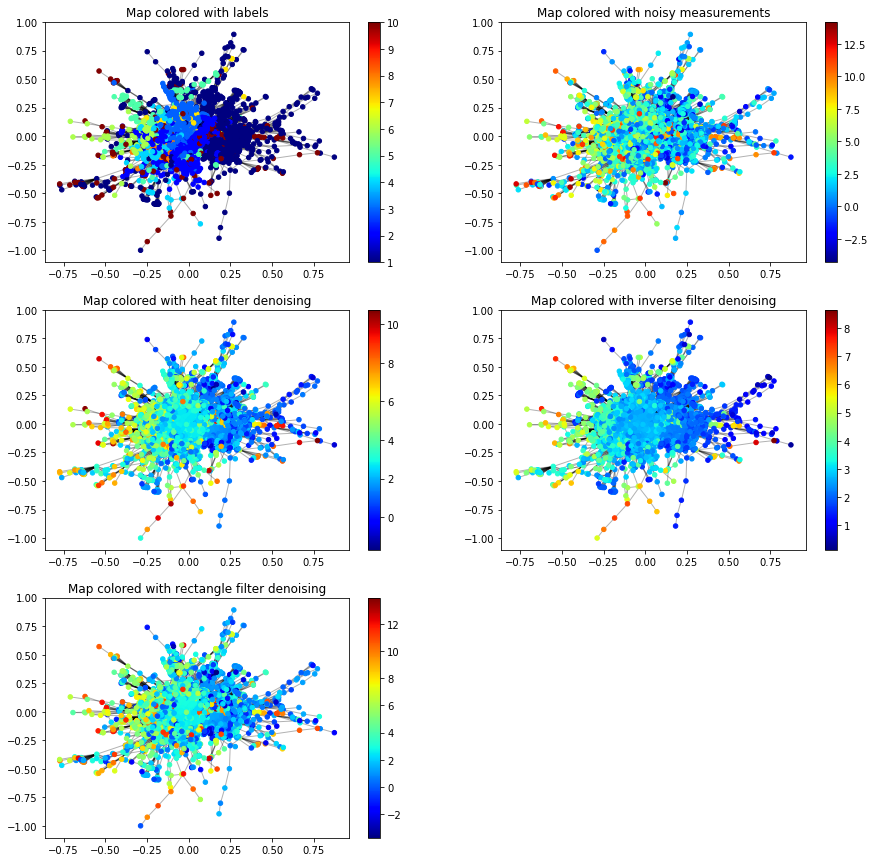

In [39]:
fig, ax = plt.subplots(3, 2, figsize=(15, 15))

nc = nx.draw_networkx_nodes(graph, coords, node_size=20, node_color=labels, cmap=plt.cm.jet, ax=ax[0,0])
nx.draw_networkx_edges(graph, coords, alpha=0.3, ax=ax[0,0])
plt.colorbar(nc, ax=ax[0,0])
ax[0,0].set_title("Map colored with labels")

nc = nx.draw_networkx_nodes(graph, coords, node_size=20, node_color=noisy_measurements, cmap=plt.cm.jet, ax=ax[0,1])
nx.draw_networkx_edges(graph, coords, alpha=0.3, ax=ax[0,1])
plt.colorbar(nc, ax=ax[0,1])
ax[0,1].set_title("Map colored with noisy measurements")

nc = nx.draw_networkx_nodes(graph, coords, node_size=20, node_color=z_heat_denoised, cmap=plt.cm.jet, ax=ax[1,0])
nx.draw_networkx_edges(graph, coords, alpha=0.3, ax=ax[1,0])
plt.colorbar(nc, ax=ax[1,0])
ax[1,0].set_title("Map colored with heat filter denoising")

nc = nx.draw_networkx_nodes(graph, coords, node_size=20, node_color=z_inv_denoised, cmap=plt.cm.jet, ax=ax[1,1])
nx.draw_networkx_edges(graph, coords, alpha=0.3, ax=ax[1,1])
plt.colorbar(nc, ax=ax[1,1])
ax[1,1].set_title("Map colored with inverse filter denoising")

nc = nx.draw_networkx_nodes(graph, coords, node_size=20, node_color=z_rect_denoised, cmap=plt.cm.jet, ax=ax[2,0])
nx.draw_networkx_edges(graph, coords, alpha=0.3, ax=ax[2,0])
plt.colorbar(nc, ax=ax[2,0])
ax[2,0].set_title("Map colored with rectangle filter denoising")

ax[2,1].remove();

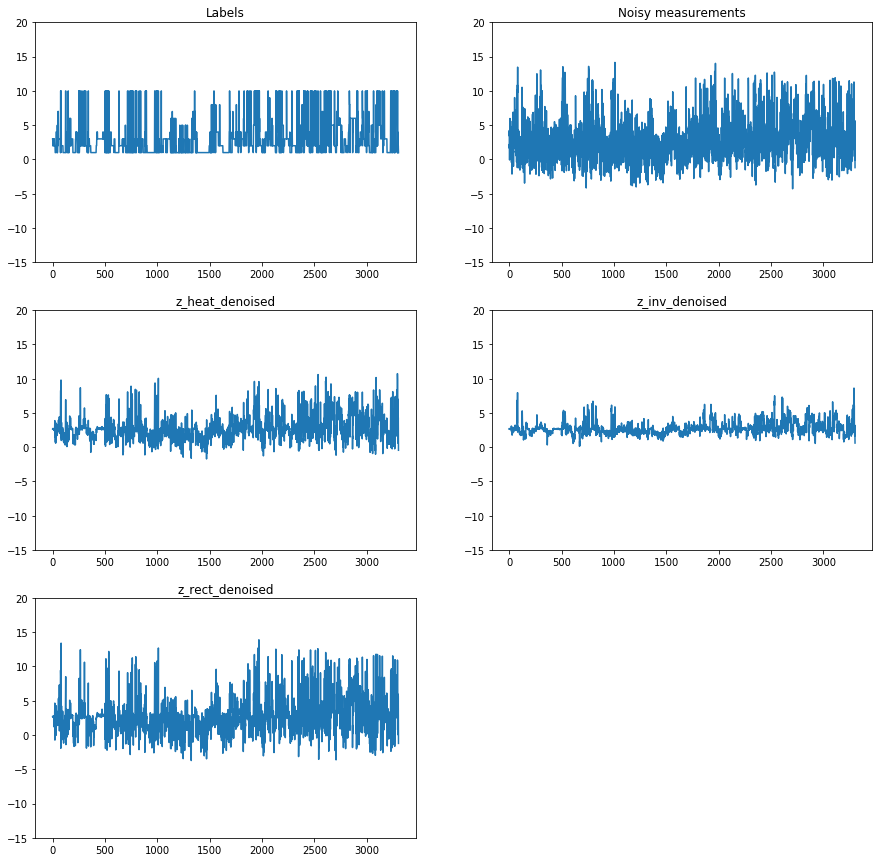

In [40]:
#pas ce qui est demandé je crois en fait, à enlever

#Effectivement t'as raison mais on garde pour le moment : plus visuel pour nous au niveau des amplitudes
#PS : les résultats sont sales, je pense que c'est parce que notre modèle diffuse trop
#problème au niveau des amplitudes. renormaliser entre 0 et 10 ?
fig, ax = plt.subplots(3, 2, figsize=(15, 15))

ax[0, 0].plot(labels)
ax[0, 0].set_title("Labels")
ax[0, 0].set_ylim(-15, 20)

ax[0, 1].plot(noisy_measurements)
ax[0, 1].set_title("Noisy measurements")
ax[0, 1].set_ylim(-15, 20)

ax[1, 0].plot(z_heat_denoised)
ax[1, 0].set_title("z_heat_denoised")
ax[1, 0].set_ylim(-15, 20)

ax[1, 1].plot(z_inv_denoised)
ax[1, 1].set_title("z_inv_denoised")
ax[1, 1].set_ylim(-15, 20)

ax[2, 0].plot(z_rect_denoised)
ax[2, 0].set_title("z_rect_denoised")
ax[2, 0].set_ylim(-15, 20)

ax[2, 1].remove()

In [41]:
rel_err_heat

0.3705101747507022

In [42]:
rel_err_inv

0.47450333962054364

In [43]:
rel_err_rect

0.43940427919962427

Finally, overlay on the same plot the GFT of all five signals above.

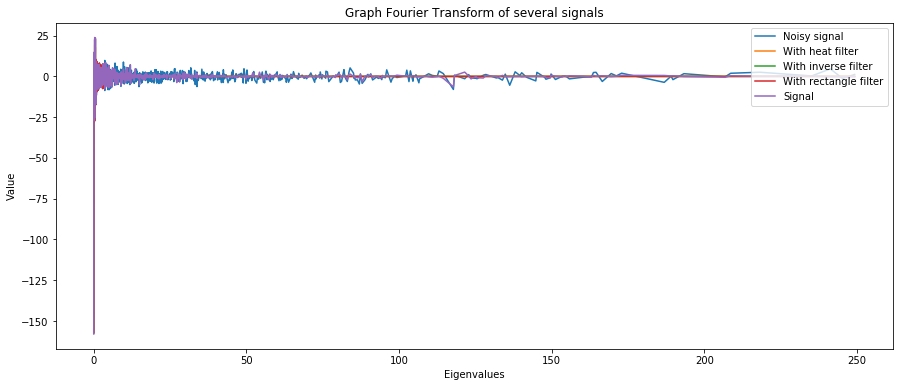

In [44]:
gft_original = GFT(labels)
gft_noise = GFT(noisy_measurements)
gft_heat = GFT(z_heat_denoised)
gft_inv = GFT(z_inv_denoised)
gft_rect = GFT(z_rect_denoised)

plt.figure(figsize=(15,6))
plt.plot(eigenvalues, gft_noise, label = 'Noisy signal')
plt.plot(eigenvalues, gft_heat, label = 'With heat filter')
plt.plot(eigenvalues, gft_inv, label = 'With inverse filter')
plt.plot(eigenvalues, gft_rect, label = 'With rectangle filter')
plt.plot(eigenvalues, gft_original, label = 'Signal')
plt.legend(loc='upper right')
plt.title('Graph Fourier Transform of several signals')
plt.ylabel('Value');
plt.xlabel('Eigenvalues');
plt.show()

### Question 12

Comment on which denoised version seems to best match the original label signal. What is the underlying assumption behind the three filtering approaches? Do you think it holds for your label signal? Why?

**For the rectangle filter, the assumption is that frequencies higher than a certain value can be neglected / are equal to zero. For the rest, I don't know.**

## 4 - Transductive learning

It is often the case in large networks that we can only afford to query properties/labels on a small subset of nodes. Nonetheless, if the underlying labels signal is "regular" enough, we might still be able to recover a good approximation of it by solving an offline variational problem, with constraints on the values of the measured nodes. 

In this section, we will be interested in solving such transductive learning problems by minimizing a (semi-) p-norm of the graph gradient applied to the signal of interest:

$$
\text{arg} \, \underset{z|_S = y}{\min} \|\nabla_G z\|_p^p,
$$

where $S$ is the set of measured nodes.

In English, we can say that we are looking for solutions with small "aggregated local variations", as measured by $\|\nabla_G z\|_p^p = \sum_{i=1}^{n} \sum_{j=1}^{n} \left( \sqrt{W_{ij}} |z[i] - z[j]| \right)^p,$ while satisfying the measurement constraints $z[i] = y[i]$ for $i \in S.$

We will work with two cases, according to the choices $p=1$ or $p=2.$ For $p=1,$ the problem is known as "interpolation by graph total-variation minimization," whereas for $p=2$ it is sometimes called "interpolation by Tikhonov regularization".

In order to solve these variational problems with the black-box solver provided to you, you will use the [pyunlocbox](https://pyunlocbox.readthedocs.io). This toolbox implements iterative solvers based on so-called ["proximal-splitting"](https://en.wikipedia.org/wiki/Proximal_gradient_method) methods.

### Question 13

Throughout this section, we will consider only a binarized version of your label signal. If your variable `labels` currently has values other than $\{-1, 1\},$ threshold them so that those are the only values taken in this vector. This can be done for example by choosing a number $t \in \mathbb{R}$ and then setting $\text{labels_bin}[i] = 1$ if $\text{labels}[i] \geq t$ and $\text{labels_bin}[i] = 0$ otherwise.

In [45]:
labels_bin = np.ones(n_nodes)
for i in range(n_nodes):
    if labels[i] != 1:  #choice : American aiports or not
        labels_bin[i] = -1

Now, subsample this binarized label signal by $70\%$ by choosing, uniformly at random, $30\%$ of the nodes whose labels we will keep.

You will do this by computing a "measurement mask" vector `w` with `1.0`'s at the measured coordinates, and $0.0$'s otherwise.

In [46]:
mn_ratio = 0.3
m = int(mn_ratio * n_nodes)  # Number of measurements.

#List of randomely ordered integers between 0 and n_nodes-1
a = np.arange(n_nodes)
np.random.seed(777) #To get comparable results
np.random.shuffle(a)

#Creation of the desired mask : 30% values are set
ratio = int(np.ceil(n_nodes*mn_ratio))
w = np.zeros(n_nodes)
for i in range(ratio):
    w[a[i]]=1 

Plot the subsampled signal on the graph. _Hint:_ you might want to set to `numpy.nan` the values of the un-measured nodes for a cleaner plot.

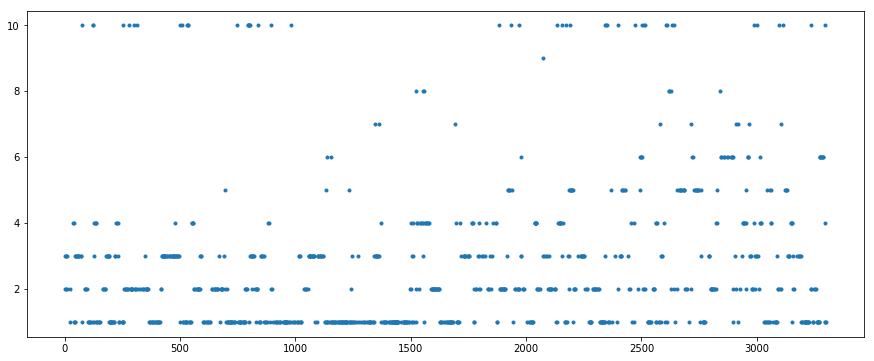

In [47]:
subsampled_signal = np.ones(n_nodes)*np.nan
for i in range(len(w)):
    if w[i]==1:
        subsampled_signal[i] = labels[i]
plt.figure(figsize=(15,6))
plt.plot(subsampled_signal,".")
plt.show()

### Interlude

For the solution of the variational problems you can use the following function as a "black-box". 

You will just need to provide a `gradient` matrix (which you should already have from Section 0), and an orthogonal projection operator `P` onto the span of the measured coordinates (made precise in the next question).

In [48]:
def graph_pnorm_interpolation(gradient, P, x0=None, p=1., **kwargs):
    r"""
    Solve an interpolation problem via gradient p-norm minimization.

    A signal :math:`x` is estimated from its measurements :math:`y = A(x)` by solving
    :math:`\text{arg}\underset{z \in \mathbb{R}^n}{\min}
    \| \nabla_G z \|_p^p \text{ subject to } Az = y` 
    via a primal-dual, forward-backward-forward algorithm.

    Parameters
    ----------
    gradient : array_like
        A matrix representing the graph gradient operator
    P : callable
        Orthogonal projection operator mapping points in :math:`z \in \mathbb{R}^n` 
        onto the set satisfying :math:`A P(z) = A z`.
    x0 : array_like, optional
        Initial point of the iteration. Must be of dimension n.
        (Default is `numpy.random.randn(n)`)
    p : {1., 2.}
    kwargs :
        Additional solver parameters, such as maximum number of iterations
        (maxit), relative tolerance on the objective (rtol), and verbosity
        level (verbosity). See :func:`pyunlocbox.solvers.solve` for the full
        list of options.

    Returns
    -------
    x : array_like
        The solution to the optimization problem.

    """

    grad = lambda z: gradient.dot(z)
    div = lambda z: gradient.transpose().dot(z)

    # Indicator function of the set satisfying :math:`y = A(z)`
    f = functions.func()
    f._eval = lambda z: 0
    f._prox = lambda z, gamma: P(z)

    # :math:`\ell_1` norm of the dual variable :math:`d = \nabla_G z`
    g = functions.func()
    g._eval = lambda z: np.sum(np.abs(grad(z)))
    g._prox = lambda d, gamma: functions._soft_threshold(d, gamma)

    # :math:`\ell_2` norm of the gradient (for the smooth case)
    h = functions.norm_l2(A=grad, At=div)

    stepsize = (0.9 / (1. + scipy.sparse.linalg.norm(gradient, ord='fro'))) ** p

    solver = solvers.mlfbf(L=grad, Lt=div, step=stepsize)

    if p == 1.:
        problem = solvers.solve([f, g, functions.dummy()], x0=x0, solver=solver, **kwargs)
        return problem['sol']
    if p == 2.:
        problem = solvers.solve([f, functions.dummy(), h], x0=x0, solver=solver, **kwargs)
        return problem['sol']
    else:
        return x0

### Question 14

During the iterations of the algorithm used for solving the variational problem, we have to make sure that the labels at the measured nodes stay the same. We will do this by means of an operator `P` which, given a vector $a \in \mathbb{R}^{N},$ returns another vector $b \in \mathbb{R}^{N}$ satisfying $b[i] = \text{labels_bin}[i]$ for every node $i$ in the set $S$ of known labels, and $b[i] = a[i]$ otherwise. Write in the cell below the function for this orthogonal projection operator `P`.

_Hint:_ remember you have already computed the mask `w`.

In [49]:
def P(a):
    b = np.zeros(len(w))
    
    for i in range(len(w)):
        if w[i] == 0:
            b[i] = a[i]
        else:
            b[i] = labels_bin[i]
            
    return b

### Question 15

Solve the variational problems for $p = 1$ and $p = 2$. Record the solution for the $1-$norm minimization under `sol_1norm_min` and the one for $2-$norm minimization under `sol_2norm_min`.

Compute also binarized versions of these solutions by thresholding the values with respect to $0$, that is, non-negative values become `1.0`, while negative values become `-1.0`. Store those binarized versions under `sol_1norm_bin` and `sol_2norm_bin`, respectively.

In [50]:
#C'est un essai mais flemme de corriger et de tout relancer. mettez x0 = np.zeros(n_nodes) idem pour x1

x0 = (np.random.random(n_nodes)-0.5)/1000  #Default xO
x1 = (np.random.random(n_nodes)-0.5)/1000 #need another x0 for norm2 because x0 is modified

In [51]:
sol_1norm_min = graph_pnorm_interpolation(gradient=gradient, P=P, x0=x0, p=1)

sol_2norm_min = graph_pnorm_interpolation(gradient=gradient, P=P, x0=x1, p=2)

threshold = 0

sol_1norm_bin = np.sign(sol_1norm_min-threshold)

sol_2norm_bin = np.sign(sol_2norm_min-threshold)

Solution found after 2 iterations:
    objective function f(sol) = 8.562619e+03
    stopping criterion: RTOL
Solution found after 84 iterations:
    objective function f(sol) = 7.877336e+03
    stopping criterion: RTOL


Plot, on your graph, the original `labels_bin` signal, as well as the solutions to the variational problems (both binarized and otherwise). Indicate on each plot the value of the relative error $\text{rel-err} = \frac{\|\text{labels_bin} - z\|_2}{\|\text{labels_bin}\|_2}$, where $z$ is the signal in the corresponding plot.

In [52]:
rel_err_1norm_bin = np.linalg.norm(labels_bin-sol_1norm_bin)/np.linalg.norm(labels_bin)
rel_err_2norm_bin = np.linalg.norm(labels_bin-sol_2norm_bin)/np.linalg.norm(labels_bin)

C:\Users\guilh\Miniconda3\envs\ntds_2018\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


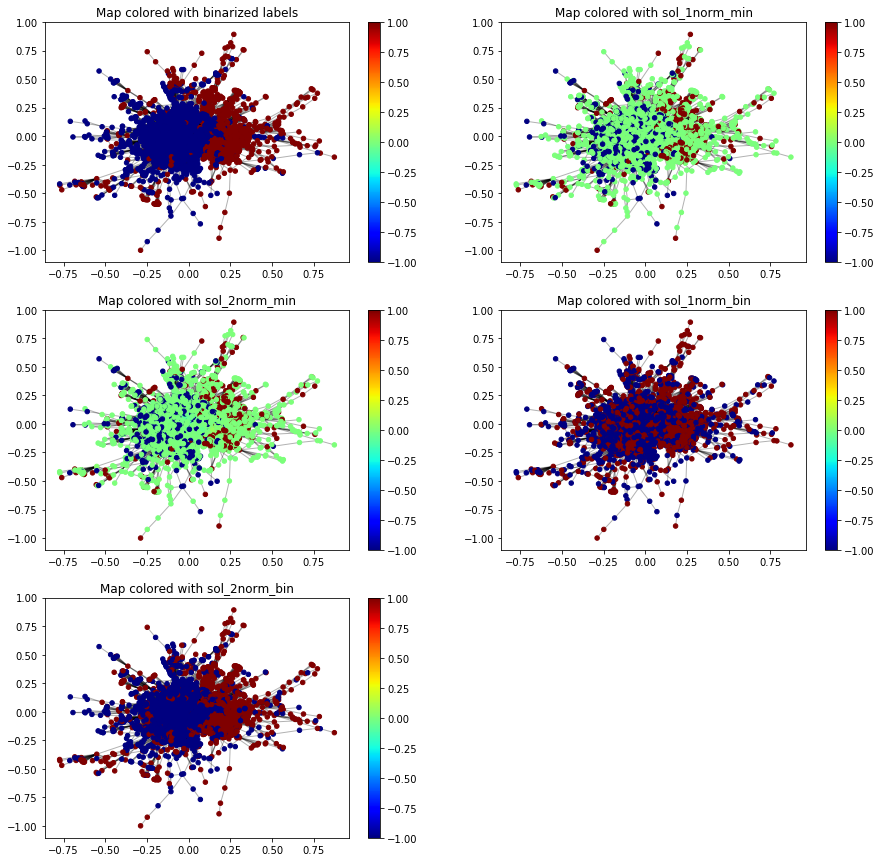

In [53]:
fig, ax = plt.subplots(3, 2, figsize=(15, 15))

nc = nx.draw_networkx_nodes(graph, coords, node_size=20, node_color=labels_bin, cmap=plt.cm.jet, ax=ax[0,0])
nx.draw_networkx_edges(graph, coords, alpha=0.3, ax=ax[0,0])
plt.colorbar(nc, ax=ax[0,0])
ax[0,0].set_title("Map colored with binarized labels")

nc = nx.draw_networkx_nodes(graph, coords, node_size=20, node_color=sol_1norm_min, cmap=plt.cm.jet, ax=ax[0,1])
nx.draw_networkx_edges(graph, coords, alpha=0.3, ax=ax[0,1])
plt.colorbar(nc, ax=ax[0,1])
ax[0,1].set_title("Map colored with sol_1norm_min")

nc = nx.draw_networkx_nodes(graph, coords, node_size=20, node_color=sol_2norm_min, cmap=plt.cm.jet, ax=ax[1,0])
nx.draw_networkx_edges(graph, coords, alpha=0.3, ax=ax[1,0])
plt.colorbar(nc, ax=ax[1,0])
ax[1,0].set_title("Map colored with sol_2norm_min")

nc = nx.draw_networkx_nodes(graph, coords, node_size=20, node_color=sol_1norm_bin, cmap=plt.cm.jet, ax=ax[1,1])
nx.draw_networkx_edges(graph, coords, alpha=0.3, ax=ax[1,1])
plt.colorbar(nc, ax=ax[1,1])
ax[1,1].set_title("Map colored with sol_1norm_bin")

nc = nx.draw_networkx_nodes(graph, coords, node_size=20, node_color=sol_2norm_bin, cmap=plt.cm.jet, ax=ax[2,0])
nx.draw_networkx_edges(graph, coords, alpha=0.3, ax=ax[2,0])
plt.colorbar(nc, ax=ax[2,0])
ax[2,0].set_title("Map colored with sol_2norm_bin")

ax[2,1].remove();

In [54]:
rel_err_1norm_bin

1.0444132474633772

In [55]:
rel_err_2norm_bin

0.6185196730552849

In [56]:
#Easier way to see the percentage of good nodes
correct1 = 0
correct2 = 0
for i in range(n_nodes):
    if labels_bin[i]==sol_1norm_bin[i]:
        correct1+=1
    if labels_bin[i]==sol_2norm_bin[i]:
        correct2+=1
print(correct1/n_nodes,correct2/n_nodes)

0.7273002421307506 0.9043583535108959


### Question 16

Now that you have got a feeling for the sort of solutions that the transductive learning problems studied can give, we will see what is the effect of the number of measurements on the accuracy of both $p-$norm minimization problems.

Towards this goal, you will write a `phase_transition()` function. This function will basically go over all the procedures that you have implemented in this section, but for varying numbers of measurements and thresholding values. It will also compute the relative error, $\text{rel-err},$ of the solutions and average them over a number of trials.

The output of the `phase_transition()` function has to be a matrix with `len(mn_ratios)` columns and `len(thresholds)` rows. Each pixel $(i,j)$ in the output matrix has to contain the average, over `n_trials` trials, of the relative error $\text{rel-err}$ in the binarized (with threshold `thresholds[i]`) solution given by `graph_pnorm_interpolation()` from observing an `mn_ratios[j]` fraction of nodes. The randomness comes from a different choice of mask `w` at each trial, hence the averaging.

The interest of this phase transition matrix is to assess what level of recovery error one could expect for a certain fraction of measurements and a certain threshold level.

**checker la fonction**

In [57]:
#regardez le code vide dans la version initiale du repository ntds_2018 si vous voulez le refaire, je pas sûr de moi
def phase_transition(mn_ratios, thresholds, n_trials, labels_bin, p, **kwargs):
    global w
    pt_matrix = np.zeros((len(thresholds),len(mn_ratios)))
    n = len(labels_bin)
    for i in range (len(thresholds)):
        for j in range (len(mn_ratios)):
            print(i,j) #See where we are in the execution of the algorithm
            trials = np.zeros(n_trials)
            for k in range(n_trials):
                
                # Create sample mask.
                a = np.arange(n)
                np.random.shuffle(a)
                ratio = int(np.ceil(n*mn_ratio))
                w = np.zeros(n)
                for l in range(ratio):
                    w[a[l]]=labels_bin[l] #w sert dans P si je comprends bien

                # Solve p-norm interpolation.
                x0 = np.zeros(n_nodes) #faut peut-être le remettre... ou pas ?
                sol = graph_pnorm_interpolation(gradient, P, x0=x0, p=p, **kwargs) 
                sol_bin = np.sign(sol-thresholds[i])
                trials[k] = np.linalg.norm(sol_bin-labels_bin)/np.linalg.norm(labels_bin)
            
            # Aggregate.
            pt_matrix[i][j] = sum(trials)/n_trials
    
    return pt_matrix

### Question 17

Pick 5 "m/n" ratios in $(0, 1)$ and 5 threshold levels in $(-1, 1)$ and run the `phase_transition()` function with `n_trials` = 20, for both $p = 1$ and $p = 2$.

In [58]:
#attention : mise en pls assurée pendant un certain temps
mn_ratios = [1/6, 2/6, 3/6, 4/6, 5/6]

thresholds = [-2/3, -1/3, 0, 1/3, 2/3]

n_trials = 20

pt_matrix_1norm = phase_transition(mn_ratios, thresholds, n_trials, labels_bin, 1, verbosity="NONE")

pt_matrix_2norm = phase_transition(mn_ratios, thresholds, n_trials, labels_bin, 2, verbosity="NONE")

0 0
0 1
0 2
0 3
0 4
1 0
1 1
1 2
1 3
1 4
2 0
2 1
2 2
2 3
2 4
3 0
3 1
3 2
3 3
3 4
4 0
4 1
4 2
4 3
4 4
0 0
0 1
0 2
0 3
0 4
1 0
1 1
1 2
1 3
1 4
2 0
2 1
2 2
2 3
2 4
3 0
3 1
3 2
3 3
3 4
4 0
4 1
4 2
4 3
4 4


Plot both phase transition matrices as images with a colorbar. Make sure to properly name the axes and title the images. 

array([[1.3304115 , 1.33162349, 1.32943803, 1.32819049, 1.33077859],
       [1.32872628, 1.32738805, 1.32921054, 1.32770065, 1.33044236],
       [0.52846254, 0.52205852, 0.52367308, 0.51542926, 0.52348308],
       [1.01838797, 1.01745882, 1.01053556, 1.01343395, 1.01461377],
       [1.01648488, 1.01266586, 1.01398031, 1.01423683, 1.01515969]])

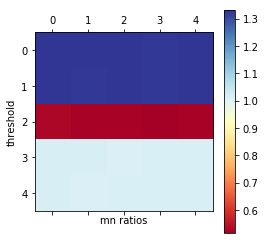

In [59]:
cm = plt.cm.get_cmap('RdYlBu')
plt.matshow(pt_matrix_1norm, cmap=cm)
plt.xlabel('mn ratios')
plt.ylabel('threshold')
cbar= plt.colorbar();
pt_matrix_1norm

array([[1.32909883, 1.33089188, 1.32998252, 1.32937024, 1.32928178],
       [1.330079  , 1.32793597, 1.33036015, 1.32934286, 1.32925599],
       [0.29589438, 0.29370795, 0.29876492, 0.29537673, 0.29505496],
       [1.01658737, 1.01543062, 1.01383686, 1.01635   , 1.01538116],
       [1.01529969, 1.01469983, 1.01476529, 1.01690584, 1.01353508]])

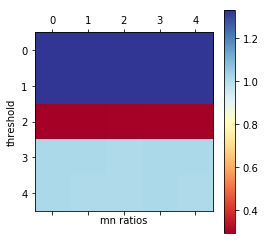

In [60]:
cm = plt.cm.get_cmap('RdYlBu')
plt.matshow(pt_matrix_2norm, cmap=cm)
plt.xlabel('mn ratios')
plt.ylabel('threshold')
cbar= plt.colorbar();
pt_matrix_2norm

### Question 18

Do the phase transition plots above provide any justification for choosing one $p-$norm interpolation over the other? Why?

**The 2-norm interpolation gives less error. It is better to take this one instead of the 1-norm interpolation.**